**Copyright 2020 Marcel Arpogaus**

    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at
 
        http://www.apache.org/licenses/LICENSE-2.0
 
    Unless required by applicable law or agreed to in writing, software
    distributed under the License is distributed on an "AS IS" BASIS,
    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    See the License for the specific language governing permissions and
    limitations under the License.

# Implementation of Bernstein-Polynomials as TensorFlow Probability Bijector

Real-world regression problems are often not deterministic, meaning that for every possible input vector *x* a whole range of outputs *y* are probable.
In such cases it is not sufficient to just predict a single point, but rather the conditioned probability density function *p(y|x)* for *y* given the input *x*.
This class of machine learning problems is commonly referred to as conditional density estimation (CDE).

Normalizing flows (NF) [16] are a type of transformation model that can be used for density estimation.
Instead of parameterizing a density function to fit the shape of the desired conditional probability distribution, they use a single simple PDF, usually a Gaussian. As a *base distribution* and pass it through a series of special transformation functions until it is most similar to the *data distribution*.
This composition of simple transformation functions allows NF based models to be very expressive, while staying computational efficient [10].

Conditioned normalizing flows can be used for complex conditional density estimation (CDE), without assuming much about their shape [4, 14].
Their expressiveness is highly dependent on the flexibility of the used transformation functions.
A recent study [14] presented a new type of flow-based transformation models especially optimized for CDE.
They joined ideas from statistical transformation models [4] as well as deep normalizing flows [16] and were able to outperform existing models for complex distributions far away from Gaussian.

Compared to the statistical transformation models the proposed deep transformation model does not require predefined features and can be trained in an end-to-end fashion from complex data.
The very expressive Bernstein polynomials are used as basis transformations [4] combined in a composition of four different transformation functions to build a NF.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector/blob/master/Bernstein_Bijector.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector/blob/master/Bernstein_Bijector.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector/master/Bernstein_Bijector.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies-&amp;-Prerequisites" data-toc-modified-id="Dependencies-&amp;-Prerequisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dependencies &amp; Prerequisites</a></span><ul class="toc-item"><li><span><a href="#Install-Dependencies" data-toc-modified-id="Install-Dependencies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Install Dependencies</a></span></li><li><span><a href="#Import-Libaries" data-toc-modified-id="Import-Libaries-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Import Libaries</a></span></li><li><span><a href="#Ensure-Reproducibility" data-toc-modified-id="Ensure-Reproducibility-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ensure Reproducibility</a></span></li></ul></li><li><span><a href="#Function-Definitions" data-toc-modified-id="Function-Definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function Definitions</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#TensorFlow-Dataset-API" data-toc-modified-id="TensorFlow-Dataset-API-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>TensorFlow Dataset API</a></span></li></ul></li><li><span><a href="#Bernstein-Polynomials" data-toc-modified-id="Bernstein-Polynomials-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bernstein Polynomials</a></span><ul class="toc-item"><li><span><a href="#Bernstein-Basis-Polynomials" data-toc-modified-id="Bernstein-Basis-Polynomials-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Bernstein Basis Polynomials</a></span></li><li><span><a href="#Bernstein-Polynomial" data-toc-modified-id="Bernstein-Polynomial-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Bernstein Polynomial</a></span></li></ul></li><li><span><a href="#Bernstein-Bijector" data-toc-modified-id="Bernstein-Bijector-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bernstein Bijector</a></span></li><li><span><a href="#Conditioned-Normalizing-Flow" data-toc-modified-id="Conditioned-Normalizing-Flow-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conditioned Normalizing Flow</a></span><ul class="toc-item"><li><span><a href="#Example:-Bimodal-Distribution" data-toc-modified-id="Example:-Bimodal-Distribution-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Example: Bimodal Distribution</a></span><ul class="toc-item"><li><span><a href="#Evaluating" data-toc-modified-id="Evaluating-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Evaluating</a></span></li><li><span><a href="#Sampling" data-toc-modified-id="Sampling-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Sampling</a></span></li></ul></li></ul></li><li><span><a href="#Normalizing-Flow-Network" data-toc-modified-id="Normalizing-Flow-Network-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Normalizing Flow Network</a></span><ul class="toc-item"><li><span><a href="#Model-Definition" data-toc-modified-id="Model-Definition-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Model Definition</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Result" data-toc-modified-id="Result-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Result</a></span></li></ul></li><li><span><a href="#Bernstein-Bijector-as-Loss" data-toc-modified-id="Bernstein-Bijector-as-Loss-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Bernstein Bijector as Loss</a></span><ul class="toc-item"><li><span><a href="#Model-Definition" data-toc-modified-id="Model-Definition-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Model Definition</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Result" data-toc-modified-id="Result-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Result</a></span></li></ul></li></ul></div>

##  Dependencies & Prerequisites

### Install Dependencies

In [1]:
try:
    from google.colab import drive
    !pip install git+https://github.com/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector.git
except:
    print('Not running in Colab')

Not running in Colab


### Import Libaries

In [2]:
import os
import pandas as pd
import numpy as np

from functools import partial

import scipy.interpolate as I

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="paper")  # improved plt styles

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

Import The Bernstein flow and loss classes.

In [5]:
from bernstein_flow.bijectors import BernsteinBijector
from bernstein_flow.distributions import BernsteinFlow
from bernstein_flow.losses import BernsteinFlowLoss

Import utility functions to visualize the flow

In [6]:
from bernstein_flow.util.visualization import vizualize_flow_from_z_domain
from bernstein_flow.util.visualization import plot_chained_bijectors
from bernstein_flow.util.visualization import plot_flow

### Ensure Reproducibility

In [7]:
np.random.seed(2)
tf.random.set_seed(2)
print("TFP Version", tfp.__version__)
print("TF  Version", tf.__version__)

TFP Version 0.11.1
TF  Version 2.3.1


## Function Definitions

We want to directly minimize the negative log-likelihood:

In [8]:
def negloglik(y_true, y_hat):
    nll = -y_hat.log_prob(y_true)
    return nll

## Data

Classic dataset containing the waiting time between eruptions and the duration of the eruption for the [Old Faithful Geyser](https://en.wikipedia.org/wiki/Old_Faithful) in [Yellowstone National Park](https://en.wikipedia.org/wiki/Yellowstone_National_Park).

Extracted from the [built-in dataset in R](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/faithful.html).

Reference: [1]

In [9]:
y = np.asarray(
    (0.6694, 0.3583, 0.6667, 0.6667, 0.6667, 0.3333, 0.7306, 0.7139, 0.3389, 0.8056, 0.3056, 0.9083, 0.2694, 0.8111,
     0.7306, 0.2944, 0.7778, 0.3333, 0.7889, 0.7028, 0.3167, 0.8278, 0.3333, 0.6667, 0.3333, 0.6667, 0.4722, 0.75,
     0.6778, 0.6194, 0.5861, 0.7444, 0.3694, 0.8139, 0.4333, 0.6917, 0.3667, 0.7944, 0.3056, 0.7667, 0.3778, 0.6889,
     0.3333, 0.6667, 0.3333, 0.6667, 0.3139, 0.7111, 0.3472, 0.7444, 0.4167, 0.6667, 0.2944, 0.7222, 0.3639, 0.7472,
     0.6472, 0.5556, 0.6222, 0.6667, 0.325, 0.8778, 0.3333, 0.6667, 0.3333, 0.6667, 0.3333, 0.6667, 0.5889, 0.3611, 0.75,
     0.3361, 0.6917, 0.7, 0.7222, 0.3222, 0.775, 0.6361, 0.6722, 0.6944, 0.7778, 0.3028, 0.6667, 0.5, 0.6667, 0.3333, 0.7417,
     0.3417, 0.7083, 0.3194, 0.7778, 0.2889, 0.7306, 0.2944, 0.7667, 0.3111, 0.7417, 0.2722, 0.8389, 0.3028, 0.85, 0.2722, 0.7139,
     0.3333, 0.6667, 0.3333, 0.7556, 0.3333, 0.6667, 0.4889, 0.7889, 0.65, 0.325, 0.6861, 0.3, 0.7778, 0.3056, 0.7833, 0.3528, 0.7972,
     0.3028, 0.6833, 0.775, 0.6667, 0.3333, 0.6667, 0.6667, 0.7028, 0.6889, 0.6556, 0.625, 0.7361, 0.4111, 0.6944, 0.6333, 0.7194,
     0.6444, 0.7806, 0.2833, 0.8278, 0.7111, 0.7639, 0.6667, 0.6667, 0.6667, 0.6667, 0.3306, 0.7667, 0.1389, 0.8194, 0.2889, 0.7639,
     0.2833, 0.7917, 0.3056, 0.75, 0.3111, 0.7417, 0.7417, 0.6667, 0.8, 0.6667, 0.6667, 0.3333, 0.6667, 0.3222, 0.7639, 0.3333, 0.6167,
     0.4778, 0.8056, 0.575, 0.7306, 0.3, 0.7333, 0.4139, 0.7528, 0.35, 0.725, 0.7278, 0.2972, 0.8194, 0.3028, 0.6667, 0.6667, 0.6667, 0.6444,
     0.3083, 0.7833, 0.3361, 0.7444, 0.3111, 0.6944, 0.3167, 0.7083, 0.5417, 0.7028, 0.3139, 0.8306, 0.3083, 0.6667, 0.3278, 0.7944, 0.6667, 0.3333,
     0.6667, 0.6667, 0.3972, 0.7361, 0.7028, 0.7278, 0.3333, 0.7417, 0.2917, 0.75, 0.2694, 0.7833, 0.4278, 0.6167, 0.7056, 0.3222, 0.725, 0.6667, 0.6667,
     0.6667, 0.7028, 0.6667, 0.6889, 0.3139, 0.7444, 0.325, 0.7028, 0.2861, 0.7417, 0.7083, 0.6611, 0.7306, 0.3278, 0.7417, 0.7111, 0.3194, 0.7361, 0.5,
     0.6667, 0.3333, 0.6667, 0.5472, 0.3056, 0.7694, 0.3056, 0.7694, 0.7667, 0.7083, 0.3222, 0.8306, 0.3278, 0.7167, 0.7, 0.7556, 0.7333, 0.7694, 0.3333,
     0.6667, 0.6667, 0.6528, 0.3333, 0.75, 0.3, 0.6667, 0.4583, 0.7889, 0.6611, 0.325, 0.8278, 0.3083, 0.8, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
     0.6667, 0.3333, 0.6667, 0.3222, 0.7222, 0.2778, 0.7944, 0.325, 0.7806, 0.3222, 0.7361, 0.3556, 0.6806, 0.3444, 0.6667, 0.6667, 0.3333),
    np.float32
)

In [10]:
x = np.ones((y.shape[0], 1))

### TensorFlow Dataset API

[`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API supports writing descriptive and efficient input pipelines

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=len(y))
dataset = dataset.batch(32)
dataset = dataset.prefetch(1)
dataset

<PrefetchDataset shapes: ((None, 1), (None,)), types: (tf.float64, tf.float32)>

In [12]:
x_sample, y_sample = next(dataset.as_numpy_iterator())
x_sample.shape, y_sample.shape

((32, 1), (32,))

## Bernstein Polynomials

### Bernstein Basis Polynomials

The Bernstein polynomial basis has been introduced by Sergei Natanovich Bernstein over 100 years ago to facilitate a constructive proof of the Weierstrass approximation theorem.
It turned out as a remarkable method for approximating any continuous function, to the desired accuracy over finite domains, and firstly found application in computer-aided geometric design.
Due to its excellent numerical stability properties, the diversification of its repertoire of applications steadily increased.
A comprehensible survey of the historical development and current state of theory, algorithms, and applications can be found in [3].
The Bernstein basis of degree $M$ on $x\in[0,1]$ is defined by:

\begin{equation}
    \operatorname{Be}_{k}^{M}(x):=
        \left(%
            \begin{array}{l}
                M \\
                k
            \end{array}%
        \right)
        (1-x)^{M-k} x^{k}, \ \text{with} \ k=0, \ldots, M
\end{equation}

The Bernstein basis polynomials have two fundamental properties, firstly they are non–negative on $x\in[0,1]$ and secondly they form a partition of unity, hence

\begin{equation}
    \sum_{i=0}^{n} Be_{i}^{M}(t)=1.
\end{equation}

The five Bernstein basis polynomials of degree $M=5$ on $x\in[0,1]$ along with the cumulative sum are are shown in the following plot.

<AxesSubplot:>

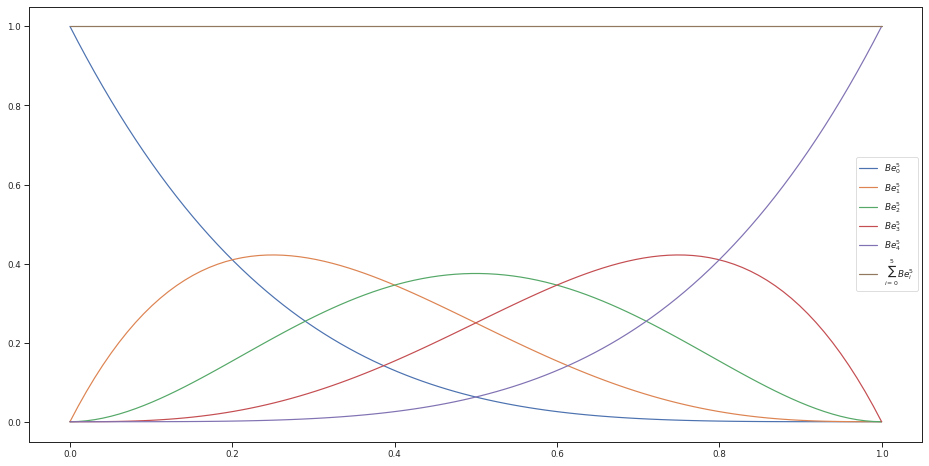

In [13]:
M = 5
x = np.linspace(0, 1, 100)
d = {}
for i in range(M):
    c = np.zeros(M).reshape(-1, 1)
    c[i] = 1
    bp = I.BPoly(c, [0, 1])
    d[f'$Be^{M}_{i}$'] = bp(np.linspace(0, 1, 100))

df = pd.DataFrame(d, index=x)
df[f'$\sum^{M}_{{i=0}} Be^{M}_i$'] = df.sum(axis='columns')
df.plot(figsize=(16, 8))

### Bernstein Polynomial

The Bernstein basis polynomials of degree $M$ form a basis of polynomials of degree at most $M$ with real coefficients. A linear combination of Bernstein basis polynomials 

\begin{equation}
    b_{M}(x)=\sum_{i=0}^{M} \vartheta_{i} \operatorname{Be}_{i}^{M}
\end{equation}

is then called a Bernstein polynomial of degree $M$, with the Bernstein coefficients $\vartheta_\nu$[3].
The following plot sows the Bernstein polynomials with increasing order $M=1,\ldots,5$, and random integer coefficients $\theta$.

<AxesSubplot:>

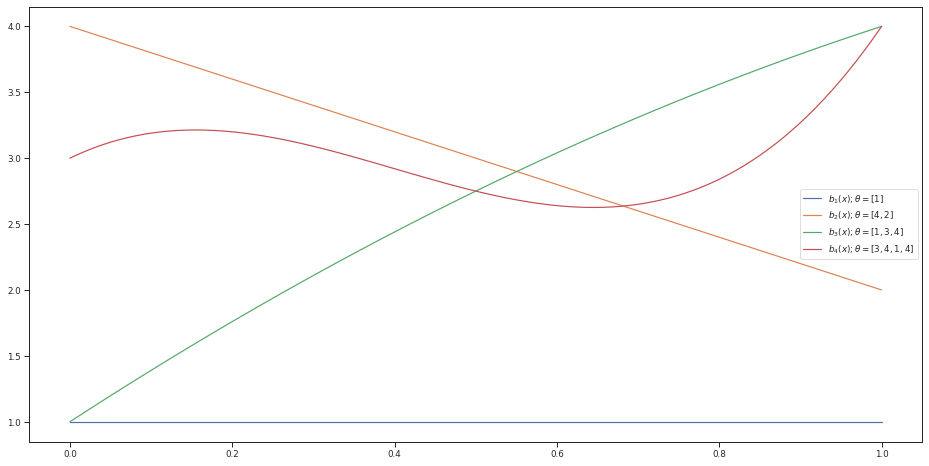

In [14]:
M = 5
x = np.linspace(0, 1, 100)
d = {}
for i in range(1, M):
    c = np.random.randint(1, M, (i, 1))
    bp = I.BPoly(c, [0, 1])
    d[f'$b_{i}(x); \\theta=[{",".join(c.flatten().astype(str))}]$'] = bp(
        np.linspace(0, 1, 100))

df = pd.DataFrame(d, index=x)
df.plot(figsize=(16, 8))

## Bernstein Bijector

Implementing the Bernstein polynomial uses the [`tfb.Bijector`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector) interface for transformations of a `Distribution` sample.

The monotonicity of a Bernstein polynomial can been ensured via linear constraints (`BernsteinBijector.constrain_theta`) what makes it technically invertible.

A closed-form solution for the inversion of higher-order Bernstein polynomials is not known.
Since extensions of the Bernstein polynomials for interpolations with *piecewise-polynomial functions* (B-Splines) exists [3] they are used to approximate the inverse of the Bernstein polynomial.
In the implementation above cubic splines have been used for the approximation using a linear interval of $10$ times the polynomial order $M$ points.

tf.Tensor(
[[-1.0744555  -0.6430366  -0.4418069   0.79479384  1.9245766   2.1403763
   2.4250433   3.163461    3.3931    ]], shape=(1, 9), dtype=float32)


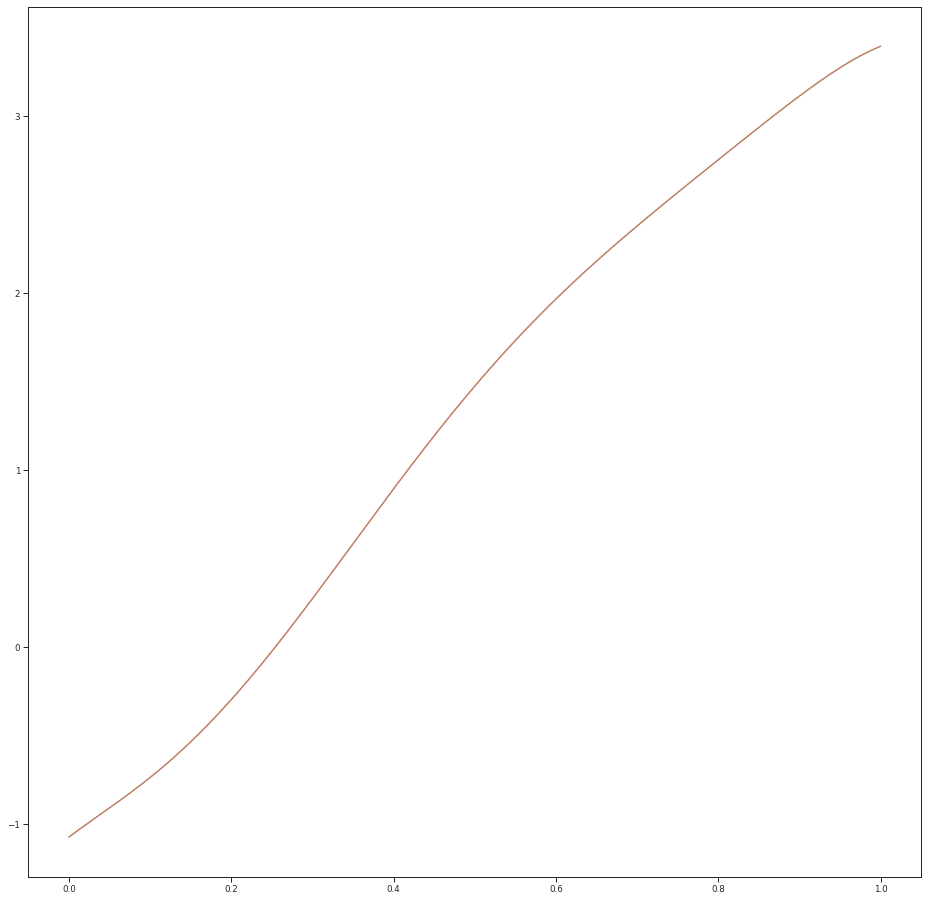

In [15]:
M = 9
theta = BernsteinBijector.constrain_theta(
    np.random.normal(0, 1, (1, M)).astype(np.float32)
)
print(theta)
bs = BernsteinBijector(
    order=M,
    theta=theta
)
yy = np.linspace(0, 1, 200, dtype=np.float32)
zz = bs.forward(yy)
# Prevent caching -> use spline interpolation
zi = zz + 1e-15 * np.random.random(zz.shape)
yyy = bs.inverse(zi)

plt.figure(figsize=(16, 16))
plt.plot(yy, zz)
plt.plot(yyy, zi)

In [16]:
f'The MSE of the interpolation in this example is {np.sum((np.squeeze(yyy)-yy)**2):.3e}$.'

'The MSE of the interpolation in this example is 5.154e-10$.'

## Conditioned Normalizing Flow

Models based on NF have only gained little attention in the research community for CDE and have predominantly been used for variational inference [6, 12] or modeling of complex multi-modal unconditional distributions, for example for image generation [5, 2] or speech synthesis [8, 9].
Compared to conditional VAE [15] and conditional GAN [7] NF based models explicitly estimate the distribution and hence the negative logarithmic likelihood becomes tractable and can be used as loss-function, what makes them attractive for CDE.
Very recent research applied NF in that context and has shown very promising results [13, 11, 17].

In the original formulation of NF by [16], rich density approximations were constructed, by transforming a simple initial density, into a more complex one.
This implementation of flows is particularly efficient for generating new samples from the learned data distribution but limited by the inefficiency of evaluating the likelihood of externally provided data since it requires inverting each $f_n$.
Depending on the specific implementation it may be sufficient to reverse that direction, to allow the evaluation of likelihoods in constant time.
The following illustration  shows a inverse conditioned normalizing flow model, transforming a complex conditioned distribution $p_y(y|x)$ step by step to a simple Gaussian distribution $p_z(z|x)$, conditioned on some value $x$. The visualization was inspired by [18].

![](../gfx/conditioned_normalizing_flow.svg)

Defining the forward mapping from the target $y$ to the base distribution, allows the density to be evaluated in constant time, even for complex transformation functions, which leads to

\begin{equation}
    z = t(y,\boldsymbol{\theta}_x)\qquad\text{with}\qquad y \sim p_z(z)
\end{equation}

with $t$ being a composition of $K$ bijectors $f_1(y, \boldsymbol{\theta}_{1}) \cdots f_K(y, \boldsymbol{\theta}_{K})$, parameterized with the corresponding parameter vector $\boldsymbol{\theta}_n=[\vartheta_1,\ldots,\vartheta_l]$.
Conditioning the transformed \emph{base distribution} $p_z(z|\mathbf{x})$ on the vector $\mathbf{x}$ is then achieved by, conditioning the parameters $\boldsymbol{\theta}_n$ on them.
A neural network can be trained to learn the mapping from the input $\mathbf{x}$ to the parameter vectors $h(\mathbf{x},\omega)=\boldsymbol{\theta}_x=[\theta_{1,x},\ldots,\theta_{K,x}]^T$, which is then used to parametrize the transformer functions $f_n(y,\theta_{n,x})$.

\begin{equation}
    \begin{aligned}
        z &= t(y|x,\boldsymbol{\theta}_x) = (f_K \circ f_{K-1} \circ \cdots \circ f_1)(y|x,\boldsymbol{\theta}_x)\\
          &= t(y,h(\mathbf{x},\omega)) = f_K(\cdots(f_1(y,\theta_{1,x} )\cdots)\theta_{M,x}
    )
    \end{aligned}
\end{equation}.

This way each input $\mathbf{x}$ yields a different parametrization of $t$ and thus results in a different transformation.

The expressiveness of the NF is highly dependent on the used bijectors.
A promising transformation model building upon the works from [4] uses the very expressive Bernstein polynomials as basis transformations combined in a composition of four different transformation functions to define the flow [14].
By joining these ideas from statistical transformation models [4] and deep normalizing flows [16], they were able to outperform existing models for complex distributions far away from Gaussian.

First a affine transformation $f_1$ is used, which scales and shifts $y$ followed by a sigmoid function to ensure the restriction to the valid range $[0, 1]$:

\begin{equation}
   \sigma \circ  f_1: \quad \tilde{y} = \sigma(a(\mathbf{x}) \cdot y - b(\mathbf{x}))
\end{equation}

To condition the scale and shift parameters $a$ and $b$ in the input vector $\mathbf{x}$, they are controlled by the output of an artificial neural network with input $\mathbf{x}$.
To ensure monotonicity the softplus activation function is used for $a$, the activation of $b$ is linear.

The second transformation $f_2$ is the transformation consisting of a Bernstein polynomial with $M+1$
parameters $\vartheta_0 , \vartheta_1,\ldots \vartheta_M$ which again are controlled by a neural network.

\begin{equation}
    f_{2}: \quad \tilde{z}=\frac{1}{M+1} \sum_{i=0}^{M} \operatorname{Be}_{i}^M(\tilde{y}) \vartheta_{i}(\mathbf{x})
\end{equation}

$Be$ is the Bernstein polynomials of order $M$, generated by the $M + 1$ beta-densities

\begin{equation}
    \operatorname{Be}_i^M(\tilde{y})=f_{i+1, M-i+1}(\tilde{y})
\end{equation}

Maintaining the monotonicity for the invertibility of $f_2$ can then easily be achieved via a linear constraint on the basis coefficients, a circumstance that the implementation in [14] also took advantage of by simply enforcing that the coefficients $\theta=[\vartheta_1,\ldots\vartheta_M]^T$ of the polynomial are in increasing order.

The last transformation in the chain $f_3$ is again a scale and shift transformation to force the output of $f_3$ into the range of the standard normal distribution.

\begin{equation}
    f_{3}: \quad z=\alpha(\mathbf{x}) \cdot \tilde{z}-\beta(\mathbf{x})
\end{equation}

The parameters $\alpha$ and $\beta$ are again controlled by a neural network, where the
softplus transformation is used to guarantee a positive $\alpha$.
The first experiments showed that the third bijector is not necessary for the performance, but accelerates training.

The final transformation function $t(y,h(\mathbf{x},\omega)): y \rightarrow z$ is then obtained by chaining the single transformation functions.

\begin{equation}\label{eq-sick-flow}
    \begin{aligned}
        z &= t(y,h(\mathbf{x},\omega)) = (f_3 \circ f_2 \circ \sigma \circ f_1)(y,h(\mathbf{x},\omega))\\
          &= (f_{3, \alpha(x), \beta(x)} \circ f_{2, \vartheta_{0}(x), \ldots, \vartheta_{M}(x)} \circ \sigma \circ f_{1, a(x), b(x)})(y,x)
    \end{aligned}
\end{equation}.

Illustration of a flow transforming from a bimodal distribution, to a standard Gaussian. Image taken from [14]:

![Visual representation of the normalizing flow](../gfx/sick_deep_transformation_models_2020_method.svg)

### Example: Bimodal Distribution

In [17]:
a1 = np.array([6], dtype=np.float32)
b1 = np.array([-3], dtype=np.float32)
theta = np.array([-2 ,  2,  3, -7, -7, -7, -7, -7, 7], dtype=np.float32)
a2 = np.array([0.2], dtype=np.float32)
b2 = np.array([-2.5], dtype=np.float32)
theta

array([-2.,  2.,  3., -7., -7., -7., -7., -7.,  7.], dtype=float32)

#### Evaluating

\begin{equation}
    p_y(y|\mathbf{x}) = p_z(t(\mathbf{y,\boldsymbol{\theta}_x})) \left|\det\nabla{t}(\mathbf{x},\boldsymbol{\theta}_x)\right|
\end{equation}

In [18]:
flow = BernsteinFlow(np.concatenate([a1,b1,theta,a2,b2]))
flow

<tfp.distributions.BernsteinFlow 'NormalTransformedDistribution' batch_shape=[1] event_shape=[] dtype=float32>

This Visualization shows how the distribution shapes when flowing through the chain of bijectors from the z-Domain:

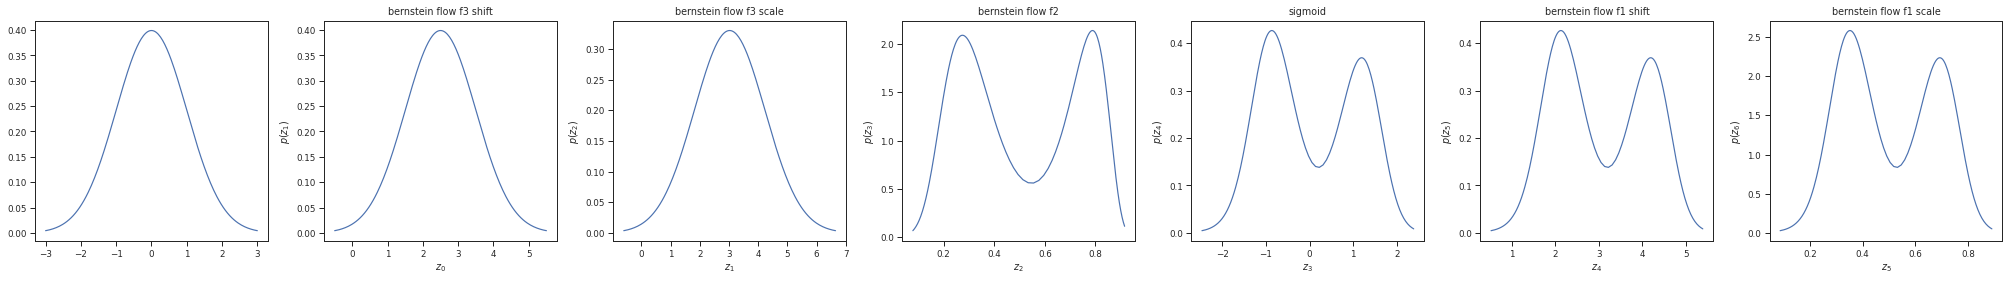

In [19]:
plot_chained_bijectors(flow)

This is the shape of the Bernstein polynomial:

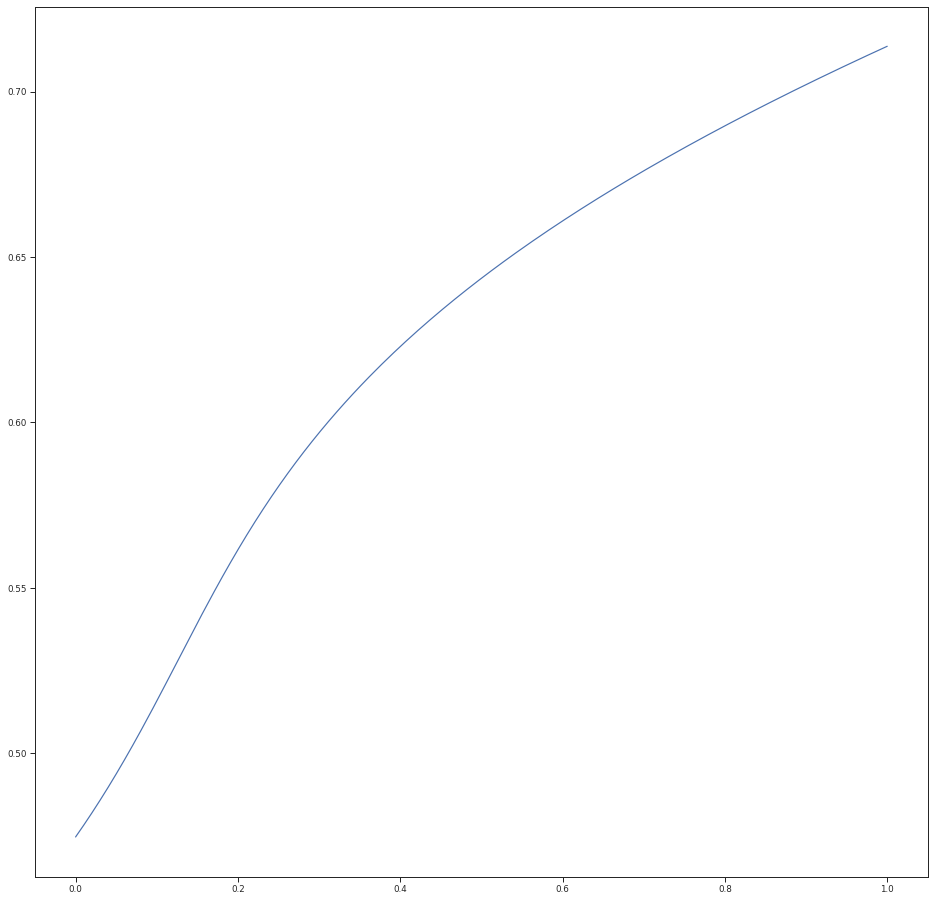

In [20]:
bs=flow.bijector#.bijector.bijectors[2]
zz = bs.forward(yy)
plt.figure(figsize=(16, 16))
plt.plot(yy, zz)

The final density function along with the transformed mean (black line), variance (green dashed) and quantiles (blue shades):

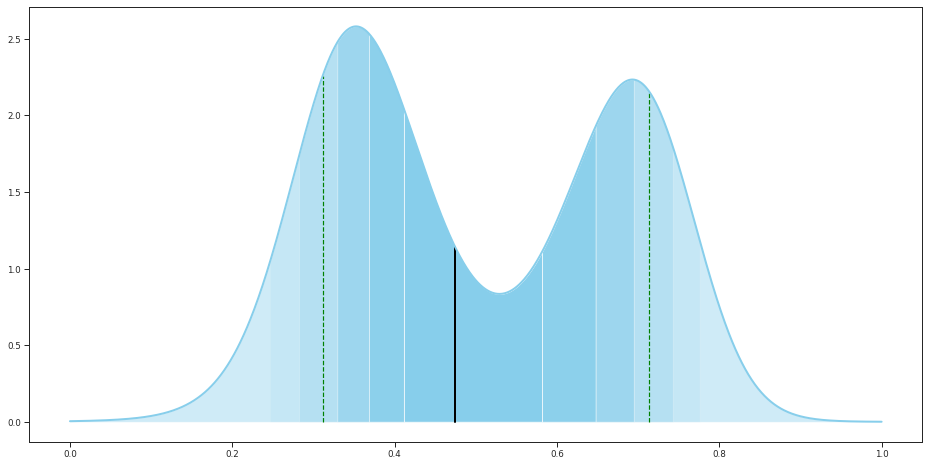

In [21]:
n = 1000
y_samples = np.linspace(0, 1, n, dtype=np.float32)
y_probs = flow.prob(y_samples[...,None])

plt.figure(figsize=(16,8))
plot_flow(flow,y_samples[...,None])

The Jacobean matrix *normalizes* the transformed distribution such that it integrates to 1:

In [22]:
dy = y_samples[1]-y_samples[0]
(sum(y_probs)*dy).numpy()

array([0.99970996], dtype=float32)

#### Sampling
\begin{equation}
    y\sim p_y(y|x) = t^{-1}(z,\boldsymbol{\theta}_x)\qquad\text{with}~z \sim p_z(z)
\end{equation}

With the approximated inverse sampling from the distribution becomes possible:

In [23]:
samples=flow.sample(8000)

/home/marcel/miniconda3/envs/tfgpu/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


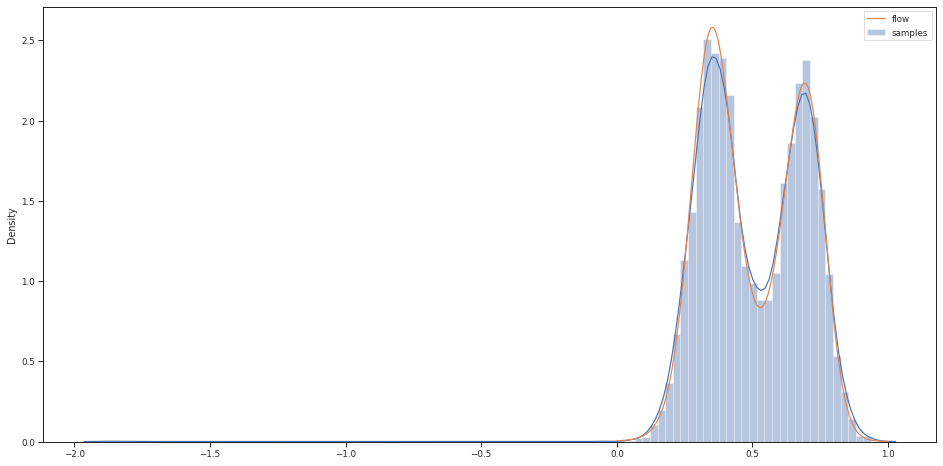

In [24]:
fig = plt.figure(figsize=(16,8))
sns.distplot(samples.numpy().flatten(),bins=100,label='samples')

plt.plot(y_samples, y_probs,label='flow')
plt.legend()

The following visualization shows how samples drawn from the z-domain get mapped to the y-domain.

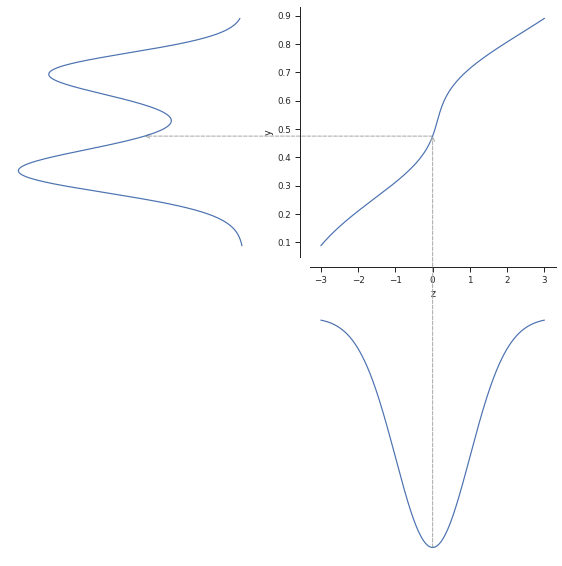

In [25]:
fig=vizualize_flow_from_z_domain(flow)

## Normalizing Flow Network

All the parameters $a,b,\theta,\alpha$ and $\beta$ are obtained from the outputs of a artificial neural network with input $\mathbf{x}$.
The positivity of $a$ and $\alpha$ is ensured by passing the raw output $\tilde{a}$ and $\tilde{\alpha}$ through a softplus activation function.
Constraining the Bernstein parameters $\theta$ to monotone increasing order is.
If $\tilde\vartheta_k$ is the $k$-th output of the parameter network for $f_2$, choosing $\vartheta_k = \vartheta_{k-1} + \exp(\tilde\vartheta_k)$ for $k>0$, does the trick.
The first output can stay unchanged and defines $\vartheta_0=\tilde\vartheta_0$.

![](../gfx/sick_architecture.svg)

### Model Definition

In [26]:
bernstein_order = 9 # Order of Bernstin polynomial

flow_model = tf.keras.Sequential()
flow_model.add(tf.keras.layers.InputLayer(input_shape = (1)))
#Here could come a gigantus network
flow_model.add(Dense(4 + bernstein_order)) # Bernstein coefficients and 2 times scale and shift
flow_model.add(tfp.layers.DistributionLambda(BernsteinFlow))
flow_model.summary()

Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                26        
_________________________________________________________________
distribution_lambda (Distrib ((1,), (1,))              0         
Total params: 26
Trainable params: 26
Non-trainable params: 0
________________________________________________

In [27]:
flow_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=negloglik
)

### Training

In [28]:
hist = flow_model.fit(
    dataset,
    epochs=700,
    verbose=False
)

(<AxesSubplot:>, -0.6858972907066345)

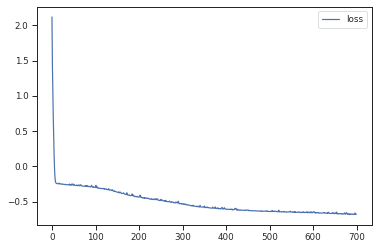

In [29]:
hist_df = pd.DataFrame(hist.history)
hist_df.plot(), hist_df.loss.min()

### Result

In [30]:
x_test = np.ones((1, 1), dtype='float32')

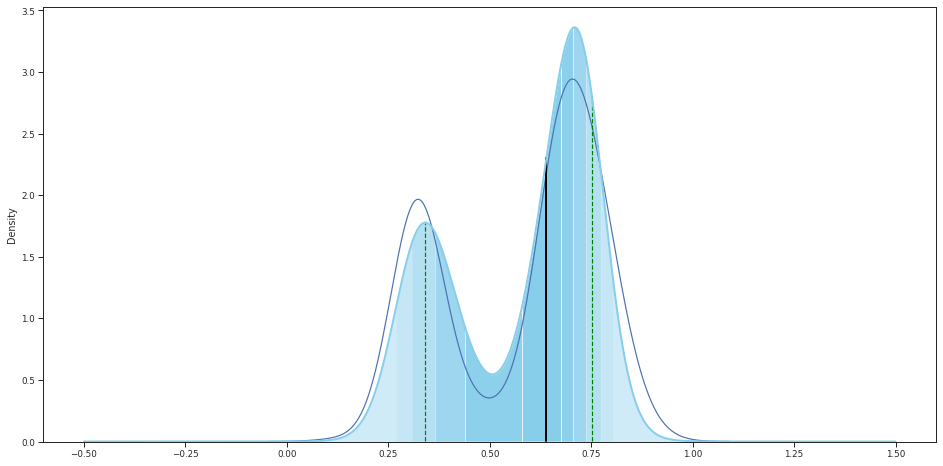

In [31]:
flow = flow_model(x_test)
yy = np.linspace(-0.5, 1.5, 1000, dtype=np.float32)
plt.figure(figsize=(16, 8))
sns.kdeplot(y)
plot_flow(flow, yy)

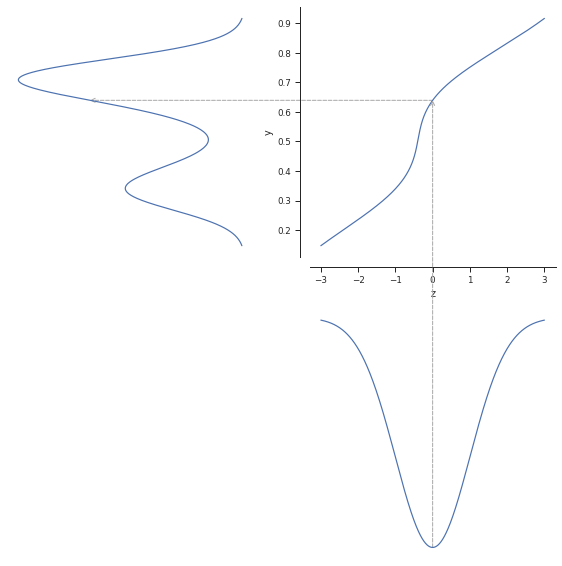

In [32]:
fig=vizualize_flow_from_z_domain(flow)

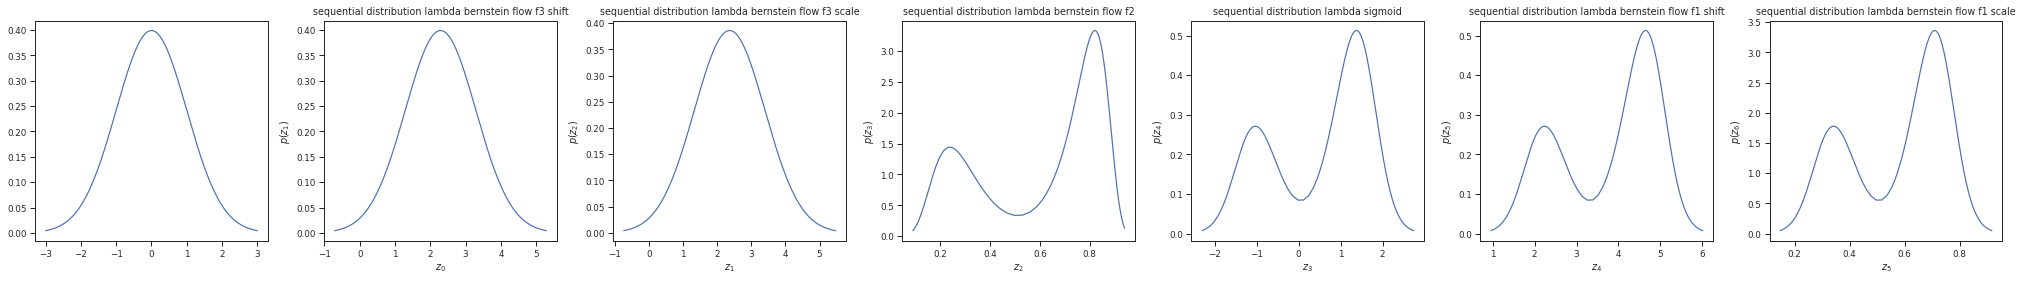

In [33]:
plot_chained_bijectors(flow)

In [34]:
b2 = flow.bijector.bijector.bijectors[0].shift
a2 = flow.bijector.bijector.bijectors[1].scale
theta = flow.bijector.bijector.bijectors[2].theta
b1 = flow.bijector.bijector.bijectors[4].shift
a1 = flow.bijector.bijector.bijectors[5].scale

In [35]:
print(f"""
a1 = {repr(a1.numpy())}
b1 = {repr(b1.numpy())}
theta = {repr(theta.numpy())}
a2 = {repr(a2.numpy())}
b2 = {repr(b2.numpy())}
""")


a1 = 6.553642
b1 = -3.2665071
theta = array([-3.2890213,  1.3046939,  1.9654974,  1.9683603,  1.9690493,
        1.9694663,  1.970037 ,  1.9744802,  7.730462 ], dtype=float32)
a2 = 0.96744615
b2 = -2.2903814



## Bernstein Bijector as Loss

The Bernstein bijector can also be used as a Keras loss function.

### Model Definition

In [36]:
bernstein_order = 9 # Order of Bernstin polynomial

flow_parameter_model = tf.keras.Sequential()
flow_parameter_model.add(tf.keras.layers.InputLayer(input_shape = (1)))
#Here could come a gigantus network
flow_parameter_model.add(Dense(4 + bernstein_order)) # Bernstein coefficients and 2 times scale and shift
flow_parameter_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                26        
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [37]:
flow_parameter_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=BernsteinFlowLoss()
)

### Training

In [38]:
# Do inference.
hist = flow_parameter_model.fit(
    dataset,
    epochs=700,
    verbose=False
)

(<AxesSubplot:>, -0.6660377979278564)

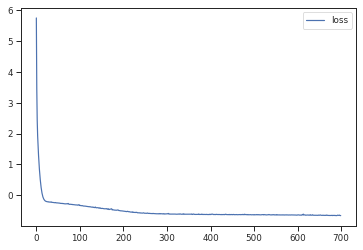

In [39]:
hist_df = pd.DataFrame(hist.history)
hist_df.plot(), hist_df.loss.min()

### Result

In [40]:
x_test = np.ones((1, 1), dtype='float32')

In [41]:
pvs = flow_parameter_model(x_test)
flow = BernsteinFlow(pvs)

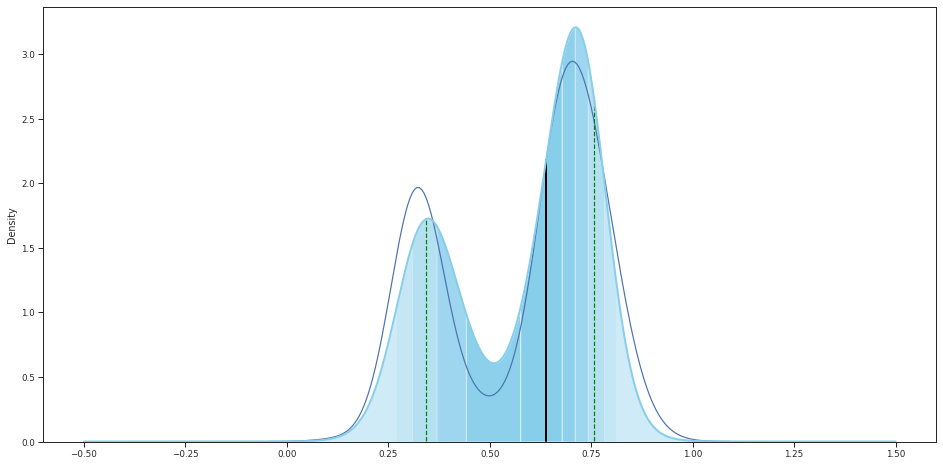

In [42]:
yy = np.linspace(-0.5, 1.5, 1000, dtype=np.float32)
plt.figure(figsize=(16, 8))
sns.kdeplot(y)
plot_flow(flow, yy[..., None])

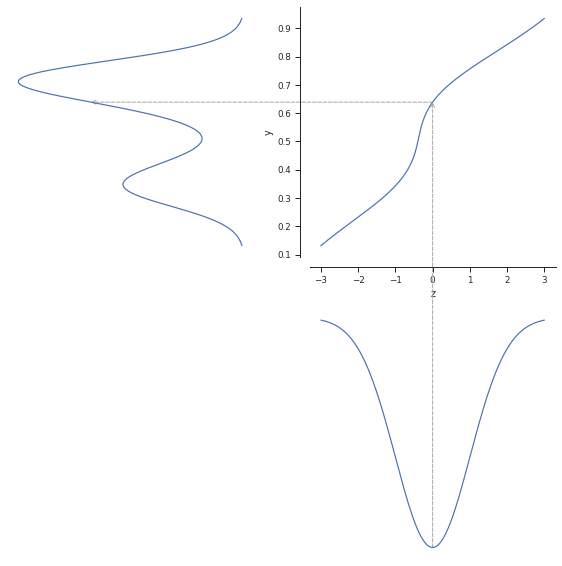

In [43]:
fig=vizualize_flow_from_z_domain(flow)

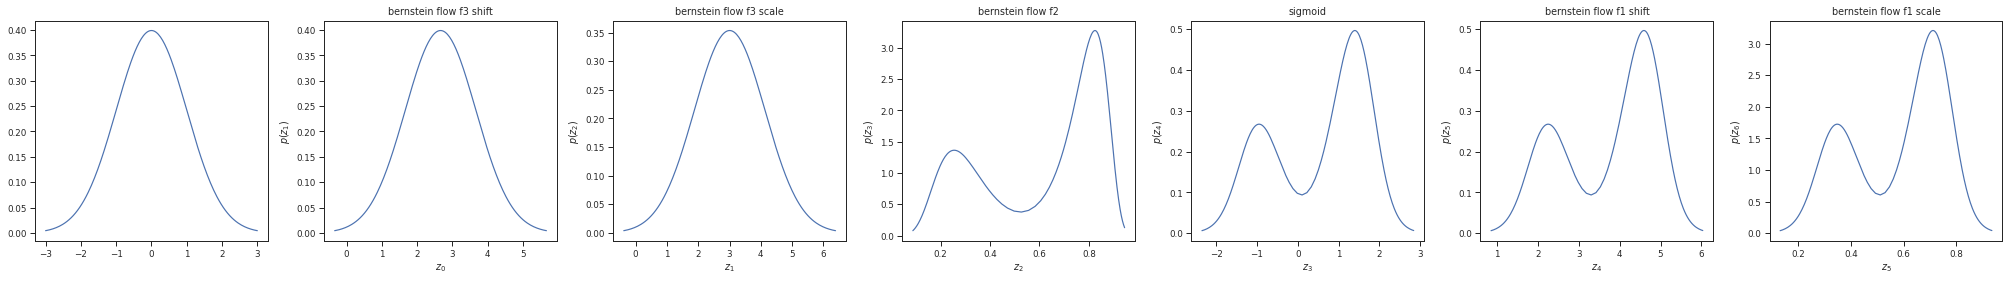

In [44]:
plot_chained_bijectors(flow)

In [45]:
b2 = flow.bijector.bijector.bijectors[0].shift.numpy().flatten()
a2 = flow.bijector.bijector.bijectors[1].scale.numpy().flatten()
theta = flow.bijector.bijector.bijectors[2].theta.numpy().flatten()
b1 = flow.bijector.bijector.bijectors[4].shift.numpy().flatten()
a1 = flow.bijector.bijector.bijectors[5].scale.numpy().flatten()

In [46]:
print(f"""
a1 = {repr(a1)}
b1 = {repr(b1)}
theta = {repr(theta)}
a2 = {repr(a2)}
b2 = {repr(b2)}
""")


a1 = array([6.455779], dtype=float32)
b1 = array([-3.1933289], dtype=float32)
theta = array([-2.576879 ,  1.2778006,  2.581427 ,  2.5848024,  2.5854416,
        2.5857766,  2.5863333,  2.5886176,  8.567568 ], dtype=float32)
a2 = array([0.8865298], dtype=float32)
b2 = array([-2.6628423], dtype=float32)



# References

[1] A. Azzalini and A. W. Bowman, “A Look at Some Data on the Old Faithful Geyser,” Journal of the Royal Statistical Society. Series C (Applied Statistics), vol. 39, no. 3, pp. 357–365, 1990, doi: 10.2307/2347385.

[2] L. Dinh, J. Sohl-Dickstein, and S. Bengio, “Density estimation using Real NVP,” arXiv:1605.08803 [cs, stat], Feb. 2017. [Online](http://arxiv.org/abs/1605.08803).

[3] R. T. Farouki, “The Bernstein polynomial basis: A centennial retrospective,” Comput. Aided Geom. Des., vol. 29, no. 6, pp. 379–419, Aug. 2012, doi: 10.1016/j.cagd.2012.03.001.

[4] T. Hothorn, L. Möst, and P. Bühlmann, “Most Likely Transformations,” Scandinavian Journal of Statistics, vol. 45, no. 1, pp. 110–134, 2018, doi: 10.1111/sjos.12291.

[5] D. P. Kingma and P. Dhariwal, “Glow: Generative Flow with Invertible 1x1 Convolutions,” arXiv:1807.03039 [cs, stat], Jul. 2018. [Online](http://arxiv.org/abs/1807.03039).

[6] D. P. Kingma, T. Salimans, R. Jozefowicz, X. Chen, I. Sutskever, and M. Welling, “Improving Variational Inference with Inverse Autoregressive Flow,” arXiv:1606.04934 [cs, stat], Jan. 2017. [Online](http://arxiv.org/abs/1606.04934).

[7] M. Mirza and S. Osindero, “Conditional Generative Adversarial Nets,” arXiv:1411.1784 [cs, stat], Nov. 2014. [Online](http://arxiv.org/abs/1411.1784).

[8] A. van den Oord et al., “WaveNet: A Generative Model for Raw Audio,” arXiv:1609.03499 [cs], Sep. 2016. [Online](http://arxiv.org/abs/1609.03499).

[9] A. van den Oord et al., “Parallel WaveNet: Fast High-Fidelity Speech Synthesis,” arXiv:1711.10433 [cs], Nov. 2017. [Online](http://arxiv.org/abs/1711.10433).

[10] G. Papamakarios, E. Nalisnick, D. J. Rezende, S. Mohamed, and B. Lakshminarayanan, “Normalizing Flows for Probabilistic Modeling and Inference,” arXiv:1912.02762 [cs, stat], Dec. 2019. [Online](http://arxiv.org/abs/1912.02762).

[11] K. Rasul, A.-S. Sheikh, I. Schuster, U. Bergmann, and R. Vollgraf, “Multi-variate Probabilistic Time Series Forecasting via Conditioned Normalizing Flows,” arXiv:2002.06103 [cs, stat], Feb. 2020. [Online](http://arxiv.org/abs/2002.06103).

[12] D. J. Rezende and S. Mohamed, “Variational Inference with Normalizing Flows,” arXiv:1505.05770 [cs, stat], Jun. 2016. [Online](http://arxiv.org/abs/1505.05770).

[13] J. Rothfuss et al., “Noise Regularization for Conditional Density Estimation,” arXiv:1907.08982 [cs, stat], Feb. 2020. [Online](http://arxiv.org/abs/1907.08982).

[14] B. Sick, T. Hothorn, and O. Dürr, “Deep transformation models: Tackling complex regression problems with neural network based transformation models,” arXiv:2004.00464 [cs, stat], Apr. 2020. [Online](http://arxiv.org/abs/2004.00464).

[15] K. Sohn, H. Lee, and X. Yan, “Learning structured output representation using deep conditional generative models,” in Advances in neural information processing systems 28, 2015, pp. 3483–3491, [Online](http://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models.pdf).

[16] E. G. Tabak and C. V. Turner, “A Family of Nonparametric Density Estimation Algorithms,” Communications on Pure and Applied Mathematics, vol. 66, no. 2, pp. 145–164, 2013, doi: 10.1002/cpa.21423.

[17] B. L. Trippe and R. E. Turner, “Conditional Density Estimation with Bayesian Normalising Flows,” arXiv:1802.04908 [stat], Feb. 2018. [Online](http://arxiv.org/abs/1802.04908).

[18] L. Weng, “Flow-based deep generative models,” lilianweng.github.io/lil-log, Oct. 2018, [Online](http://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html).